# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


### Problem Statement

My goal is, for each type of offer,
    1. Identify the characteristics of a successful offer
    2. Based on the characteristics identified above, Predict if a particular user would take up an offer


### Solution Statement

Using the data provided, I address the above two goals using 3 classification supervised machine learning models, feeding in the data from three different offer types. I use the models to uncover the feature importances to identify the drivers of offer success, while using the model to predict if a user would take up an offer. Lastly, I will explore the characteristics of users who do or do not take up an offer.

### Data Exploration

In [ ]:
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline

# read in the json files
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)
profile = pd.read_json('profile.json', orient='records', lines=True)
transcript = pd.read_json('transcript.json', orient='records', lines=True)

In [141]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [142]:
portfolio.isna().sum(axis=0)

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

In [143]:
portfolio.shape

(10, 6)

In [144]:
portfolio.groupby('offer_type')['id'].nunique()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

In [145]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [146]:
profile.isna().sum(axis=0)

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [147]:
profile.shape

(17000, 5)

In [148]:
profile.groupby('gender').size()

gender
F    6129
M    8484
O     212
dtype: int64

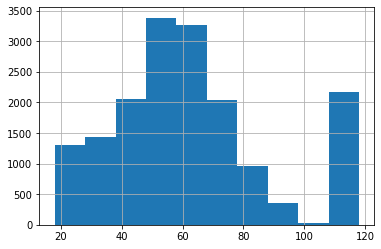

In [149]:
profile.age.hist()

In [150]:
profile[profile['age']>100].age.unique()

array([118, 101])

In [151]:
profile[profile['age']==118].isna().sum(axis=0)

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

There are 2,175 records with missing gender, income and age values (default as 118)

In [152]:
profile['became_member_on'].describe()

count    1.700000e+04
mean     2.016703e+07
std      1.167750e+04
min      2.013073e+07
25%      2.016053e+07
50%      2.017080e+07
75%      2.017123e+07
max      2.018073e+07
Name: became_member_on, dtype: float64

In [153]:
transcript.isna().sum(axis=0)

person             0
event              0
time               0
amount        167581
offer_id           0
channels           0
difficulty         0
duration           0
offer_type         0
reward             0
dtype: int64

In [154]:
transcript.groupby('event')['person'].nunique()

event
offer completed    12774
offer received     16994
offer viewed       16834
transaction        16578
Name: person, dtype: int64

In [155]:
transcript['person'].nunique()

17000

In [ ]:
transcript=pd.concat([transcript, transcript['value'].apply(pd.Series)], axis=1)

In [ ]:
transcript['offer_id_new']=np.where(transcript['offer id'].isnull() & transcript['offer_id'].notnull(),transcript['offer_id'],transcript['offer id'])

In [ ]:
transcript.drop(['offer id','offer_id'],axis=1,inplace=True)

In [ ]:
transcript.rename(columns={'offer_id_new':'offer_id'},inplace=True)

In [157]:
transcript.tail(50)

,person,event,time,amount,offer_id,channels,difficulty,duration,offer_type,reward
306484,fffad4f4828548d1b5583907f2e9906b,transaction,120,6.26,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,5,bogo,5.0
306485,fffad4f4828548d1b5583907f2e9906b,offer received,168,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,3,informational,0.0
306486,fffad4f4828548d1b5583907f2e9906b,offer viewed,168,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,3,informational,0.0
306487,fffad4f4828548d1b5583907f2e9906b,transaction,198,5.63,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,3,informational,0.0
306488,fffad4f4828548d1b5583907f2e9906b,transaction,312,8.20,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,3,informational,0.0
306489,fffad4f4828548d1b5583907f2e9906b,transaction,324,2.05,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,3,informational,0.0
306490,fffad4f4828548d1b5583907f2e9906b,transaction,402,8.14,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,3,informational,0.0
306491,fffad4f4828548d1b5583907f2e9906b,offer received,408,NaN,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,5,bogo,5.0
306492,fffad4f4828548d1b5583907f2e9906b,offer viewed,510,NaN,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,5,bogo,5.0
306493,fffad4f4828548d1b5583907f2e9906b,transaction,516,12.18,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,5,bogo,5.0


### Data Preprocessing

Since event 'transaction' does not have any offer id attached, we cant yet merge transcript data with portfolio data.

For assigning offer id to transaction event, we first need to understand the possible customers and subsequent scenarios:

**1. People who are influenced and successfully convert - Successful Offers:**

- 'offer received' -> 'offer viewed' -> 'transaction' -> 'offer completed' (BOGO/discount offers)
- 'offer received' -> 'offer viewed' -> 'transaction' (informational offers - must be within validity/period of offer)

**2. People who received and viewed an offer but did not successfully convert - Unsuccessful Offers:**

- 'offer received' -> 'offer viewed'

**3. People who purchase/complete offers regardless of awareness of any offers - No need to send any offers:**

- 'transaction'
- 'offer received' -> 'transaction' -> 'offer completed' -> 'offer viewed'
- 'transaction' -> 'offer received' -> 'offer completed' -> 'offer viewed'
- 'offer received' -> 'transaction' -> 'offer viewed' -> 'offer completed'
- 'offer received' -> 'transaction' (informational offers)
- 'offer received' -> 'transaction' -> 'offer viewed' (informational offers)

**4. People who received offers but no action taken - Low priority customers:**

- 'offer received'

Hence, we can eliminate groups 3 & 4 from modelling scope. Though, we will try to find common traits of such customers

Now, we can easily assign offer id to 'transaction' events based on the id of 'offer viewed' event which occured prior to it.

In [ ]:
#Sorting by customer and time
transcript=transcript.sort_values(['person','time']).drop(['value'],axis=1)

In [159]:
df=transcript[['time','offer_id','person','event']][(transcript['event']=='transaction') | (transcript['event']=='offer viewed')].sort_values(['person','time'])

In [160]:
df['offer_id']=df['offer_id'].ffill()

In [ ]:
transcript=transcript.merge(df,how='left',on=['person','time','event'])

In [ ]:
transcript['offer_id']=np.where(transcript['offer_id_x'].isnull(),transcript['offer_id_y'],transcript['offer_id_x'])

In [ ]:
transcript.drop(['offer_id_x','offer_id_y'],axis=1,inplace=True);

In [ ]:
#merge portfolio dataset again to get offer data for the transaction events
transcript=transcript.merge(portfolio,how='left',left_on='offer_id',right_on='id')

In [ ]:
transcript['reward']=np.where(transcript['reward_x'].isnull(),transcript['reward_y'],transcript['reward_x'])
transcript.drop(['reward_x','reward_y','id'],axis=1,inplace=True)

Now, we need to flag successful offer. So, as long as the events 'offer viewed', 'transaction', and 'offer completed' occur in the corrrect sequence of time for the same offer, we can be assured that it is a transaction and/or completed offer occurring only after an offer is viewed.

In [161]:
df = transcript[(transcript['event']=='offer viewed') | (transcript['event']=='transaction') | (transcript['event']=='offer completed')].copy()

In [162]:
df['offer_id_previous'] = df.groupby(['person','offer_id'])['offer_id'].shift()

In [163]:
#flag a completed transaction/offer completed as long as the previous offer id consists of events in the same sample space
df['valid_completed']=np.where(df['offer_id_previous']==df['offer_id'],1,0)

Imposing at least 1 Offer viewed event condition on each person-offer id combination

In [164]:
check = df.groupby(['person','offer_id','event']).size().reset_index()

In [165]:
check1 = check[['person','offer_id']][check['event']=='offer viewed'].drop_duplicates()
check1['flag']=1

In [166]:
df1 = df.merge(check1,on=['person','offer_id'],how='left')

In [167]:
df1['valid_completed']=np.where(df1['flag'].isna(),0,df1['valid_completed'])

In [168]:
#get only offer received events
offers_received=transcript[transcript['event']=='offer received']

#ensure all columns are the same between datasets to be appended
offers_received['offer_id_previous']=np.nan
offers_received['valid_completed']=np.nan

#append datasets to complete dataset of transactions
df_transcript=offers_received.append(df1)

#sort values
df_transcript=df_transcript.sort_values(['person','time'])

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [169]:
transcript_bogo = df_transcript[df_transcript['offer_type']=='bogo']
transcript_discount = df_transcript[df_transcript['offer_type']=='discount']
transcript_info = df_transcript[df_transcript['offer_type']=='informational']

In [170]:
grp_bogo = transcript_bogo[['person','offer_id']][(transcript_bogo['valid_completed']==1) & (transcript_bogo['event']=='offer completed')].groupby(['person','offer_id']).count().reset_index()

In [171]:
grp_discount = transcript_discount[['person','offer_id']][(transcript_discount['valid_completed']==1) & (transcript_discount['event']=='offer completed')].groupby(['person','offer_id']).count().reset_index()

In [172]:
print("Successful offers:\nBogo:{}\nDiscount:{}".format(grp_bogo.shape[0],grp_discount.shape[0]))

Successful offers:
Bogo:10252
Discount:11347


Now we will separate group 2 and group 4 unique person-offer_ids for BOGO and discount offers as we just need to look at Unsuccessful Offers - the subset of people with offer received, offer viewed, but no conversion events. We will assume that every person who views an offer would have had an offer received event prior.

In [173]:
bogo_offers_received_only=transcript_bogo[['person','offer_id']][transcript_bogo['event']=='offer received'].groupby(['person','offer_id']).count().reset_index()

In [174]:
discount_offers_received_only=transcript_discount[['person','offer_id']][transcript_discount['event']=='offer received'].groupby(['person','offer_id']).count().reset_index()

In [175]:
bogo_conversion_ids=transcript_bogo[['person','offer_id']][(transcript_bogo['event']=='transaction') | (transcript_bogo['event']=='offer completed') ].groupby(['person','offer_id']).count().reset_index()
discount_conversion_ids=transcript_discount[['person','offer_id']][(transcript_discount['event']=='transaction') | (transcript_discount['event']=='offer completed') ].groupby(['person','offer_id']).count().reset_index()

In [176]:
bogo_merge=bogo_conversion_ids.merge(bogo_offers_received_only,how='right',on=['person','offer_id'],indicator=True)
discount_merge=discount_conversion_ids.merge(discount_offers_received_only,how='right',on=['person','offer_id'],indicator=True)

In [177]:
bogo_merge.groupby(['_merge']).count()

,person,offer_id
_merge,,
left_only,0,0
right_only,4729,4729
both,20592,20592


In [178]:
discount_merge.groupby(['_merge']).count()

,person,offer_id
_merge,,
left_only,0,0
right_only,6415,6415
both,18901,18901


So, we see 4,729 and 6,415 unique person-offer_id pairs that have offer received events, but no conversion events for Bogo and Discount offers respectively. These would be considered offers in group 2 and 4 within each offer type, according to our definition above

People with an offer viewed event in this subset are definitely in group 2, based on our assumption that everyone with an offer viewed event has an offer received event prior.

In [ ]:
#Getting Group 2 for Bogo
grp_2_4=bogo_merge[bogo_merge['_merge']=='right_only']
grp_2_4=grp_2_4.merge(df_transcript,how='left',on=['person','offer_id'])
bogo_grp2=grp_2_4[['person','offer_id']][grp_2_4['event']=='offer viewed'].groupby(['person','offer_id']).count().reset_index()
grp_2_4.drop(['_merge'],axis=1,inplace=True)
bogo_grp4 = grp_2_4.merge(bogo_grp2[['person','offer_id']],how='left',indicator=True)
bogo_grp4 = bogo_grp4[bogo_grp4['_merge']=='left_only']

In [ ]:
#Getting Group 2 for Discount
grp_2_4=discount_merge[discount_merge['_merge']=='right_only']
grp_2_4=grp_2_4.merge(df_transcript,how='left',on=['person','offer_id'])
discount_grp2=grp_2_4[['person','offer_id']][grp_2_4['event']=='offer viewed'].groupby(['person','offer_id']).count().reset_index()
grp_2_4.drop(['_merge'],axis=1,inplace=True)
discount_grp4 = grp_2_4.merge(discount_grp2[['person','offer_id']],how='left',indicator=True)
discount_grp4 = discount_grp4[discount_grp4['_merge']=='left_only']

Group 3 people have conversion events but no prior offer viewed event. For BOGO and discount offers, they would be people with offer completed events that have valid_completed != 1.

In [ ]:
bogo_grp3 = transcript_bogo[['person','offer_id']][(transcript_bogo['event']=='offer completed') & (transcript_bogo['valid_completed']!=1)].groupby(['person','offer_id']).count().reset_index()

In [ ]:
discount_grp3 = transcript_discount[['person','offer_id']][(transcript_discount['event']=='offer completed') & (transcript_discount['valid_completed']!=1)].groupby(['person','offer_id']).count().reset_index()

Creating Final datasets - Taking Groups 1 & 2 and defining successful offers

In [ ]:
grp_bogo['successful_offer']=1
bogo_grp2['successful_offer']=0
bogo_final = grp_bogo.append(bogo_grp2)

In [ ]:
grp_discount['successful_offer']=1
discount_grp2['successful_offer']=0
discount_final = grp_discount.append(discount_grp2)

Creating the same for Informational offers, but first need to take care of parameter - validity of offer

In [ ]:
transcript_info['day_offer']=transcript_info['time']/24
transcript_info.drop(['time','offer_id_previous'],axis=1,inplace=True)

In [ ]:
transcript_info=transcript_info.sort_values(['person','day_offer','event','offer_id'])

In [ ]:
transcript_info['diff_info']=transcript_info[((transcript_info['event']=='offer received') | (transcript_info['event']=='transaction'))].groupby(['person','offer_id'])['day_offer'].diff()

In [ ]:
transcript_info['valid_completed_duration']=np.nan
transcript_info.loc[transcript_info['diff_info']<=transcript_info['duration'],'valid_completed_duration']=1
transcript_info['valid_completed_duration']=transcript_info['valid_completed_duration'].fillna(value=0)

Now, 4 different scenarios are possible:
 - valid_completed=1 and valid_completed_duration=0 => completed transaction after offer viewed event, but not within duration
 - valid_completed=0/null and valid_completed_duration=1 => completed transaction within duration, but with no offer viewed event prior
 - valid_completed=1 and valid_completed_duration=1 => completed transaction within duration, with offer viewed event **(effective offer)**
 - valid_completed=0/null and valid_completed_duration=0 => did not complete transaction within duration, no offer viewed event prior

We can see that:
 - Scenarios 1 and 2 can be considered to be actions that would put the customer into our Group 3 of customer
 - Scenario 4 can be considered in group 4


In [ ]:
transcript_info['effective_offer']=np.where(((transcript_info['valid_completed']==1) & (transcript_info['valid_completed_duration']==1)),1,0)
grp1_info=transcript_info[['person','offer_id']][transcript_info['effective_offer']==1].groupby(['person','offer_id']).sum().reset_index()

In [ ]:
info_offers_received_only=transcript_info[['person','offer_id']][transcript_info['event']=='offer received'].groupby(['person','offer_id']).count().reset_index()
info_conversion_ids=transcript_info[['person','offer_id']][(transcript_info['event']=='transaction') | (transcript_info['event']=='offer completed') ].groupby(['person','offer_id']).count().reset_index()
info_merge=info_conversion_ids.merge(info_offers_received_only,how='right',on=['person','offer_id'],indicator=True)
info_merge.groupby(['_merge']).count()

In [ ]:
#Getting Group 2 and 4 for Info
grp_2_4=info_merge[info_merge['_merge']=='right_only']
grp_2_4=grp_2_4.merge(df_transcript,how='left',on=['person','offer_id'])
info_grp2=grp_2_4[['person','offer_id']][grp_2_4['event']=='offer viewed'].groupby(['person','offer_id']).count().reset_index()
grp_2_4.drop(['_merge'],axis=1,inplace=True)
info_grp4 = grp_2_4.merge(info_grp2[['person','offer_id']],how='left',indicator=True)
info_grp4 = info_grp4[info_grp4['_merge']=='left_only']

In [ ]:
# Group 3

#scenario 1
grp3_1=transcript_info[['person','offer_id']][(transcript_info['event']=='transaction')&(transcript_info['valid_completed']!=1) & (transcript_info['valid_completed_duration']==1)].groupby(['person','offer_id']).count().reset_index()
#scenario 2
grp3_2=transcript_info[['person','offer_id']][(transcript_info['event']=='transaction')&(transcript_info['valid_completed']==1) & (transcript_info['valid_completed_duration']!=1)].groupby(['person','offer_id']).count().reset_index()
grp3_info=grp3_1.append(grp3_2)

In [ ]:
grp1_info['successful_offer']=1
info_grp2['successful_offer']=0
info_final = grp1_info.append(info_grp2)

Finally, we have split our customers into 4 different segments and also identified successful & unsuccessful offers !!

Now, we will do some **feature engineering** & create some additional features for model building

In [ ]:
#Feature - Membership tenure days
i=0
for df in [info_final,bogo_final,discount_final]:
    df=df.merge(profile,how='left',left_on='person',right_on='id')
    df['year']=pd.Series([int(str(x)[:4]) for x in df['became_member_on']])
    df['month']=pd.Series([int(str(x)[-3]) for x in df['became_member_on']])
    df['day']=pd.Series([int(str(x)[-2:]) for x in df['became_member_on']])
    df=df.drop(['became_member_on'],axis=1)
    df.loc[df['year'] == 2018, 'membership_tenure_days'] = (30*df['month'])+df['day']
    df.loc[df['year'] != 2018, 'membership_tenure_days'] = ((2018-df['year'])*365)+(30*df['month'])+df['day']
    df=df.drop(['year','month','day'],axis=1)
    i += 1
    if i==1:
        info_final = df.copy()
    elif i==2:
        bogo_final = df.copy()
    else:
        discount_final = df.copy()        

In [ ]:
# Feature - Day of receiving first offer
df_transcript['day_offer']=df_transcript['time']/24

In [ ]:
df_transcript['day_offer']=df_transcript['day_offer'].round()

In [ ]:
df=df_transcript[['person','offer_id','day_offer']][df_transcript['event']=='offer received']

In [ ]:
df=df.groupby(['person','offer_id'])['day_offer'].min().reset_index()

Merging features with datasets

In [ ]:
bogo_final=bogo_final.merge(df,how='left',on=['person','offer_id'])
bogo_final.drop(['id'],axis=1,inplace=True)

In [ ]:
info_final=info_final.merge(df,how='left',on=['person','offer_id'])
info_final.drop(['id'],axis=1,inplace=True)
discount_final=discount_final.merge(df,how='left',on=['person','offer_id'])
discount_final.drop(['id'],axis=1,inplace=True)

Removing rows with null values in gender & income columns

In [ ]:
bogo_final.dropna(inplace=True)
info_final.dropna(inplace=True)
discount_final.dropna(inplace=True)

In [ ]:
def prep_df(df):
        
    #merge with portfolio to get offer details
    df=df.merge(portfolio,how='left',left_on='offer_id',right_on='id')
    df = df.drop(['id'],axis=1)

    #convert channels into categorical variables
    channels = df['channels'].apply(pd.Series)
    channels = channels.rename(columns={0:'web',1:'email',2:'mobile',3:'social'})
    df=pd.concat([df[:], channels[:]], axis=1)
    df['web']=np.where(df['web']=='web',1,0)
    df['email']=np.where(df['email']=='email',1,0)
    df['mobile']=np.where(df['mobile']=='mobile',1,0)
    df['social']=np.where(df['social']=='social',1,0)
    df=df.drop(['channels'],axis=1)
    
    #convert gender column into dummy variables
    df=pd.concat([df[:],pd.get_dummies(df['gender'],prefix='gender')],axis=1)
    df=df.drop(['gender'],axis=1)

    return df

In [ ]:
offers_discount=prep_df(discount_final)
offers_bogo=prep_df(bogo_final)

In [ ]:
def prep_info_df(df):
        
    #merge with portfolio to get offer details
    df=df.merge(portfolio,how='left',left_on='offer_id',right_on='id')
    df = df.drop(['id'],axis=1)

    #convert channels into categorical variables
    df['web']= np.nan
    df.loc[pd.Series(['web' in df['channels'][x] for x in range(len(df['channels']))]),'web']=1
    df['web']=df['web'].fillna(value=0)
    
    df['email']= np.nan
    df.loc[pd.Series(['email' in df['channels'][x] for x in range(len(df['channels']))]),'email']=1
    df['email']=df['email'].fillna(value=0)
    
    df['mobile']= np.nan
    df.loc[pd.Series(['mobile' in df['channels'][x] for x in range(len(df['channels']))]),'mobile']=1
    df['mobile']=df['mobile'].fillna(value=0)
    
    df['social']= np.nan
    df.loc[pd.Series(['social' in df['channels'][x] for x in range(len(df['channels']))]),'social']=1
    df['social']=df['social'].fillna(value=0)
    
    df=df.drop(['channels'],axis=1)
    
    #convert gender column into dummy variables
    df=pd.concat([df[:],pd.get_dummies(df['gender'],prefix='gender')],axis=1)
    df=df.drop(['gender'],axis=1)

    return df

In [ ]:
offers_info=prep_info_df(info_final)

In [182]:
offers_info.head()

,person,offer_id,successful_offer,age,income,membership_tenure_days,day_offer,reward,difficulty,duration,offer_type,web,email,mobile,social,gender_F,gender_M,gender_O
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,33,72000.0,506.0,14.0,0,0,4,informational,1.0,1.0,1.0,0.0,0,1,0
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,33,72000.0,506.0,7.0,0,0,3,informational,0.0,1.0,1.0,1.0,0,1,0
2,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,1,59,90000.0,824.0,21.0,0,0,3,informational,0.0,1.0,1.0,1.0,1,0,0
3,0020ccbbb6d84e358d3414a3ff76cffd,5a8bc65990b245e5a138643cd4eb9837,1,24,60000.0,771.0,17.0,0,0,3,informational,0.0,1.0,1.0,1.0,1,0,0
4,003d66b6608740288d6cc97a6903f4f0,3f207df678b143eea3cee63160fa8bed,1,26,73000.0,566.0,14.0,0,0,4,informational,1.0,1.0,1.0,0.0,1,0,0


In [183]:
#check for class balance in datasets
print(offers_bogo[['person','successful_offer']].groupby('successful_offer').count()/len(offers_bogo))
print(offers_discount[['person','successful_offer']].groupby('successful_offer').count()/len(offers_discount))
print((offers_info[['person','successful_offer']].groupby('successful_offer').count()/len(offers_info)))

                    person
successful_offer          
0                 0.180058
1                 0.819942
                    person
successful_offer          
0                 0.138255
1                 0.861745
                    person
successful_offer          
0                 0.262529
1                 0.737471


### Model Implementation

Creating standard functions for data preparation for modelling

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from time import time
from sklearn.linear_model import Ridge

In [ ]:
def data_prep(df,drop_cols):
    target = df['successful_offer']
    features = df.drop(drop_cols,axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(features,target, test_size=0.20, random_state=50)

    #fit and transform scaling on training data
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)

    #scale test data
    X_test=scaler.transform(X_test)
    return X_train,X_test,y_train, y_test

In [ ]:
def train_predict(learner, X_train, y_train, X_test, y_test): 
    results = {}
    
    #Fit the learner to the training data and get training time
    start = time() 
    learner = learner.fit(X_train, y_train)
    end = time() 
    results['train_time'] = end-start
    
    # Get predictions on the test set(X_test), then get predictions on training set
    start = time() 
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time() 
    
    # Calculate the total prediction time
    results['pred_time'] = end-start
    
    #add training accuracy to results
    results['training_score']=learner.score(X_train,y_train)
    
    #add testing accuracy to results
    results['testing_score']=learner.score(X_test,y_test)
     
    print("{} trained on {} samples.".format(learner.__class__.__name__, len(y_train)))
    print("MSE_train: %.4f" % mean_squared_error(y_train,predictions_train))
    print("MSE_test: %.4f" % mean_squared_error(y_test,predictions_test))
    print("Training accuracy:%.4f" % results['training_score'])
    print("Test accuracy:%.4f" % results['testing_score'])
    print(classification_report(y_test, predictions_test,digits=4))
    return results

In [ ]:
def comparison(model1,model2,name):
    
    results = {}
    for model in [model1, model2]:
        model_name = model.__class__.__name__ + '_' +name
        results[model_name] = {}
        results[model_name]= train_predict(model, X_train, y_train, X_test, y_test)
    return pd.DataFrame(results)

**BOGO Offers !**

In [184]:
drop_cols_prep=['person','offer_id','successful_offer','offer_type']
X_train, X_test, y_train, y_test=data_prep(offers_bogo,drop_cols_prep)

#Initialize the model - baseline is DT model, bogo_1 model is RF model
baseline = DecisionTreeClassifier(criterion='entropy',max_depth=5,random_state=2,min_samples_split=90,min_samples_leaf=50)
bogo_1 = RandomForestClassifier(random_state=2,max_depth= 10, max_features= 'auto',n_estimators=100)

results=comparison(baseline,bogo_1,'bogo_1')

DecisionTreeClassifier trained on 9708 samples.
MSE_train: 0.1725
MSE_test: 0.1953
Training accuracy:0.8275
Test accuracy:0.8047
              precision    recall  f1-score   support

           0     0.4175    0.0941    0.1536       457
           1     0.8219    0.9695    0.8896      1970

    accuracy                         0.8047      2427
   macro avg     0.6197    0.5318    0.5216      2427
weighted avg     0.7457    0.8047    0.7510      2427

RandomForestClassifier trained on 9708 samples.
MSE_train: 0.1403
MSE_test: 0.1842
Training accuracy:0.8597
Test accuracy:0.8158
              precision    recall  f1-score   support

           0     0.5781    0.0810    0.1420       457
           1     0.8223    0.9863    0.8968      1970

    accuracy                         0.8158      2427
   macro avg     0.7002    0.5336    0.5194      2427
weighted avg     0.7763    0.8158    0.7547      2427



Since Random Forest gives a slightly better performance than Decision Tree on unseen test dataset, I will go with Random Forest as the final choice. 
Accuracy - 81.58% vs 80.47%
F1 Score - 75.47 vs 75.10

**DISCOUNT Offers !**

In [185]:
drop_cols_prep=['person','offer_id','successful_offer','offer_type']
X_train, X_test, y_train, y_test=data_prep(offers_discount,drop_cols_prep)

#Initialize the model - baseline is DT model, discount_1 model is RF model
discount_1 = RandomForestClassifier(random_state=2,max_depth= 10, max_features= 'auto',n_estimators=100)

results=comparison(baseline,discount_1,'discount_1')

DecisionTreeClassifier trained on 9958 samples.
MSE_train: 0.1384
MSE_test: 0.1378
Training accuracy:0.8616
Test accuracy:0.8622
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       343
           1     0.8622    1.0000    0.9260      2147

    accuracy                         0.8622      2490
   macro avg     0.4311    0.5000    0.4630      2490
weighted avg     0.7435    0.8622    0.7985      2490



/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RandomForestClassifier trained on 9958 samples.
MSE_train: 0.1171
MSE_test: 0.1341
Training accuracy:0.8829
Test accuracy:0.8659
              precision    recall  f1-score   support

           0     0.6552    0.0554    0.1022       343
           1     0.8683    0.9953    0.9275      2147

    accuracy                         0.8659      2490
   macro avg     0.7618    0.5254    0.5148      2490
weighted avg     0.8390    0.8659    0.8138      2490



Again RF gave better performance compared to baseline DT
Accuracy - 86.59% vs 86.22%
F1 Score - 81.38 vs 79.85

**INFORMATIONAL Offers !**

In [186]:
drop_cols_prep=['person','offer_id','successful_offer','offer_type']
X_train, X_test, y_train, y_test=data_prep(offers_info,drop_cols_prep)

#Initialize the model - baseline is DT model, discount_1 model is RF model
info_1 = RandomForestClassifier(random_state=2,max_depth= 10, max_features= 'auto',n_estimators=100)

results=comparison(baseline,info_1,'info_1')

DecisionTreeClassifier trained on 5555 samples.
MSE_train: 0.2468
MSE_test: 0.2664
Training accuracy:0.7532
Test accuracy:0.7336
              precision    recall  f1-score   support

           0     0.4889    0.1196    0.1921       368
           1     0.7506    0.9549    0.8405      1021

    accuracy                         0.7336      1389
   macro avg     0.6197    0.5373    0.5163      1389
weighted avg     0.6812    0.7336    0.6687      1389

RandomForestClassifier trained on 5555 samples.
MSE_train: 0.1768
MSE_test: 0.2621
Training accuracy:0.8232
Test accuracy:0.7379
              precision    recall  f1-score   support

           0     0.5227    0.1250    0.2018       368
           1     0.7525    0.9589    0.8432      1021

    accuracy                         0.7379      1389
   macro avg     0.6376    0.5419    0.5225      1389
weighted avg     0.6916    0.7379    0.6733      1389



RF vs baseline DT
Accuracy - 73.79% vs 73.36%
F1 Score - 67.33 vs 66.87
Since data size of Informational models is almost half of that of Bogo/Discount offers, I believe that has caused slightly reduced relative performance. 

#### Characteristics of successful offer through feature importances

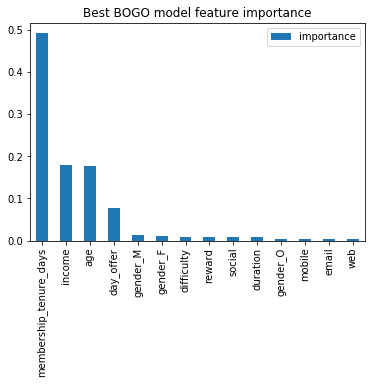

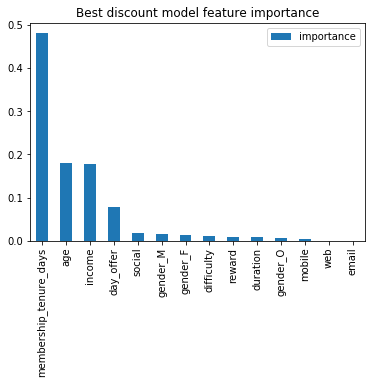

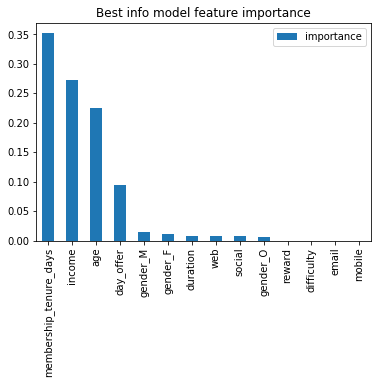

In [187]:
#BOGO model
drop_cols=['person','offer_id','successful_offer','offer_type']
features = offers_bogo.drop(drop_cols,axis=1)

feature_importances = pd.DataFrame(bogo_1.feature_importances_,
                                   index = features.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.plot.bar()
plt.title('Best BOGO model feature importance')
plt.show()

#DISCOUNT model
features = offers_discount.drop(drop_cols,axis=1)
feature_importances = pd.DataFrame(discount_1.feature_importances_,
                                   index = features.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.plot.bar()
plt.title('Best discount model feature importance')
plt.show()

#INFO model
features = offers_info.drop(drop_cols,axis=1)
feature_importances = pd.DataFrame(info_1.feature_importances_,
                                   index = features.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.plot.bar()
plt.title('Best info model feature importance')
plt.show()

Checking on the feature importance to analyse the main drivers of a successful offer, we can see that the most important driver of effective offers across all three are the tenure of membership. However, the 2nd most important feature is mostly between age and income as they share roughly equal importance across the three models. 3rd most important feature is also consistent across the models, i.e. day of offer.

For a BOGO offer, the membership tenure is the most important feature, Income, age and day_offer are the 2nd, 3rd and 4th most important features, and rest being very small in their proportions.

For a discount offer, after the membership tenure, age and income are the next most important variables, with proportions very similar to bogo offer. 

The feature importances for the informational offer models are more distributed compared to the BOGO and discount models, with income being the 2nd most important feature. Age is the third and day_offer being the 4th.

#### Exploring Characteristics of all 4 groups of customers 

In [ ]:
# Group 1 & 2
group1 = bogo_final.append(discount_final)
group1 = group1.append(info_final)
group2 = group1[group1['successful_offer']==0]
group1 = group1[group1['successful_offer']==1]

In [ ]:
# Group 3
group3 = bogo_grp3.append(discount_grp3)
group3 = group3.append(grp3_info)
group3 = group3.merge(profile,how="left",left_on="person",right_on="id")
group3.drop('id',axis=1,inplace=True)
group3['year']=pd.Series([int(str(x)[:4]) for x in group3['became_member_on']])
group3['month']=pd.Series([int(str(x)[-3]) for x in group3['became_member_on']])
group3['day']=pd.Series([int(str(x)[-2:]) for x in group3['became_member_on']])
group3=group3.drop(['became_member_on'],axis=1)
group3.loc[group3['year'] == 2018, 'membership_tenure_days'] = (30*group3['month'])+group3['day']
group3.loc[group3['year'] != 2018, 'membership_tenure_days'] = ((2018-group3['year'])*365)+(30*group3['month'])+group3['day']
group3=group3.drop(['year','month','day'],axis=1)

In [ ]:
# Group 4
group4 = bogo_grp4.append(discount_grp4)
group4 = group4.append(info_grp4)
group4 = group4.merge(profile,how="left",left_on="person",right_on="id")
group4.drop('id',axis=1,inplace=True)
group4['year']=pd.Series([int(str(x)[:4]) for x in group4['became_member_on']])
group4['month']=pd.Series([int(str(x)[-3]) for x in group4['became_member_on']])
group4['day']=pd.Series([int(str(x)[-2:]) for x in group4['became_member_on']])
group4=group4.drop(['became_member_on'],axis=1)
group4.loc[group4['year'] == 2018, 'membership_tenure_days'] = (30*group4['month'])+group4['day']
group4.loc[group4['year'] != 2018, 'membership_tenure_days'] = ((2018-group4['year'])*365)+(30*group4['month'])+group4['day']
group4=group4.drop(['year','month','day'],axis=1)

In [195]:
def plot_hist(variable,bins=None):
    df1 = group1[['person',variable]][group1['age']!=118].drop_duplicates()
    df2 = group2[['person',variable]][group2['age']!=118].drop_duplicates()
    df3 = group3[['person',variable]][group3['age']!=118].drop_duplicates()
    df4 = group4[['person',variable]][group4['age']!=118].drop_duplicates()
    plt.hist(df1[variable],alpha=0.5, label='group 1',bins=bins)
    plt.hist(df2[variable], alpha=0.5, label='group 2',bins=bins)
    plt.hist(df3[variable], alpha=0.5, label='group 3',bins=bins)
    plt.hist(df4[variable], alpha=0.5, label='group 4',bins=bins)
    plt.legend(loc='upper right')
    plt.title('distribution of '+ variable + ' between group 1-4')
    plt.show()

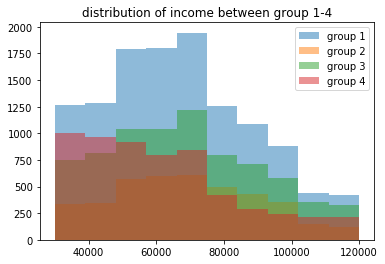

In [189]:
#plot distribution of income
plot_hist('income')

Across the 4 segments, most people fall within the middle range of income (50K - 100K). The income distribution between the 4 segments are relatively similar.

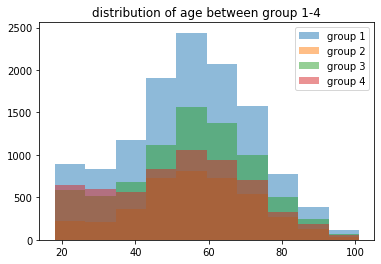

In [190]:
#plot ditribution of age
plot_hist('age')

Age distribution looks relatively similar between the 4 groups as well, with most people between the age 40-80 years old.

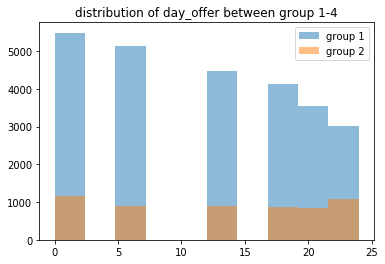

In [196]:
#plot day of offer
plot_hist('day_offer')

Looking at the day on which offer is made, after an offer is made, it looks like proportion of failure of an offer is slightly higher towards the end of the month. This may be because disposable income generally decreases towards the end of month as customers are waiting to receive their month-end salaries.

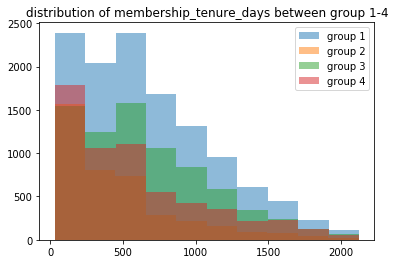

In [191]:
#plot tenure of membership
plot_hist('membership_tenure_days')

The distribution of membership tenure also looks similar between the 4 segments, with most people between 0-1000 days of tenure. Lastly, let's look at gender.

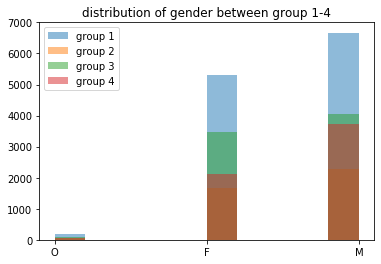

In [194]:
#plot gender
plot_hist('gender')

It appears as though there are not much demographic characteristic differences between the 4 groups, at least in the current data provided, apart from gender where females seem to have a higher tendency to make purchase irrespective of the offer.

### Conclusion

**Characteristics of Successful Offer:**
Feature importance given by all 3 models were that the tenure of a member is the biggest predictor of the effectiveness of an offer. Further, the top 4 variables were the same - membership tenure, income, age and day of offer. However, income and age switched orders depending on offer type.

For BOGO and discount offers, the distribution of feature importances were relatively equal. However, for informational offers, the distribution is slightly more balanced, with income the second most important variable.

Females seem to have a higher tendency to make purchase irrespective of the offer. Hence, offers should be more targeted towards males

Lastly, proportion of failure of an offer is slightly higher towards the end of the month. Hence, offers should be made more towards beginning/middle of month to achieve higher conversion.

In short, Optimum offer targeting is:
**Target males during initial few days of the month, who have a membership tenure of less than 1000 days, are 40-80 years old and have income between 50k-100k**

**Predict if a particular user would take up an offer:**
My decision to use 3 separate models to predict the effectiveness of each offer type ended up with good accuracy for the BOGO and discount models (81.58% for BOGO and 86.59% for discount), while slightly less accurate performance for informational offers (73.79%). All 3 models have vastly superior performance as compared to their corresponding baseline models. 

While I am quite happy with the 80% and above accuracy for BOGO and discount models, I would regard 74% as acceptable in a business setting for informational offers as there is minimal cost involved to inform users of a product.